# Assess the identified markers for mortality in pediatric sepsis

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler

#from rdea.eval.cross_validation import do_cross_validation, do_cross_validation_with_feature_selection
from rdea.eval.evaluate import do_train_test
from rdea.filters.embedded import EmbeddedFilter
from rdea.filters.mrmr import MRMRP
from rdea.utils.help_functions import model_based_relevance, auc_relevance, load_DEGs


import matplotlib.pyplot as plt
%matplotlib inline   
import seaborn as sns
import warnings

# Comment these lines if you are not using Mac OS
import matplotlib as mpl
mpl.use('MacOSX')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Set random seed
seed = 7
np.random.seed(seed)

ModuleNotFoundError: No module named 'xgboost'

## Inputs and parameters

In [2]:
# ========== INPUTS ==========

# in and out files
data_file = './data/GSE49711_Train.csv'
markers_file = './results/NB/fs_scores.csv'
test_file = './data/GSE49711_Test.csv'
degs_file = './data/GSE49711_Train_DEGs.txt'

#out_file = './results/sepsis/fs_scores.csv'
#is_save_results = True

# data pre-processing
is_normalize_samples = False
is_normalize_columns = True
norm_filter = MinMaxScaler()

# experiment
label = 'Died'

# No of markers
min_markers = 1
max_markers = 15

# classifiers
models = [
  ('RF', RandomForestClassifier(n_estimators=100,  random_state=seed)),
  ('LR', SGDClassifier(loss="log", penalty="l2", random_state=seed)),
  ('XGB', XGBClassifier(objective="binary:logistic", n_estimators=100, n_jobs=4, random_state=seed)),
 ]


<hr>
<b>Do not modify the code below this line.</b><br>
<hr>

In [3]:
# load markers 

markers_df = pd.read_csv(markers_file)
features = markers_df['feature'].values

print('{} markers loaded!'.format(len(features)))

markers_sets = []
for i in range(min_markers,max_markers+1):
    markers_sets.append(('top_'+str(i),features[:i]))

33 markers loaded!


In [4]:
# Load data 
df = pd.read_csv(data_file)
print('Shape of {0} is {1}'.format(data_file, df.shape))
y_train = df[label]

Shape of ./data/GSE49711_Train.csv is (249, 11575)


In [5]:
# Load test data 
df_test = pd.read_csv(test_file)
print('Shape of {0} is {1}'.format(test_file, df_test.shape))
y_test = df[label]

Shape of ./data/GSE49711_Test.csv is (249, 11575)


## Searching for optimal model

Performance reported using:	 ACC	Sn	Sp	MCC	AUC
top_1: ['NPM1']
Shape of training data is (249, 1)
Shape of test data is (249, 1)
RF: [0.73493976 0.33333333 0.83838384 0.17430842 0.60858586]
top_2: ['NPM1' 'ATP2B4']
Shape of training data is (249, 2)
Shape of test data is (249, 2)
RF: [0.76305221 0.29411765 0.88383838 0.19970888 0.68003565]
top_3: ['NPM1' 'ATP2B4' 'WFDC2']
Shape of training data is (249, 3)
Shape of test data is (249, 3)
RF: [0.79116466 0.39215686 0.89393939 0.31131946 0.69632601]
top_4: ['NPM1' 'ATP2B4' 'WFDC2' 'CSRP2']
Shape of training data is (249, 4)
Shape of test data is (249, 4)
RF: [0.75100402 0.29411765 0.86868687 0.1771579  0.67488612]
top_5: ['NPM1' 'ATP2B4' 'WFDC2' 'CSRP2' 'RET']
Shape of training data is (249, 5)
Shape of test data is (249, 5)
RF: [0.76706827 0.31372549 0.88383838 0.21937305 0.66993464]
top_6: ['NPM1' 'ATP2B4' 'WFDC2' 'CSRP2' 'RET' 'MAD2L1']
Shape of training data is (249, 6)
Shape of test data is (249, 6)
RF: [0.76706827 0.29411765 0.88888

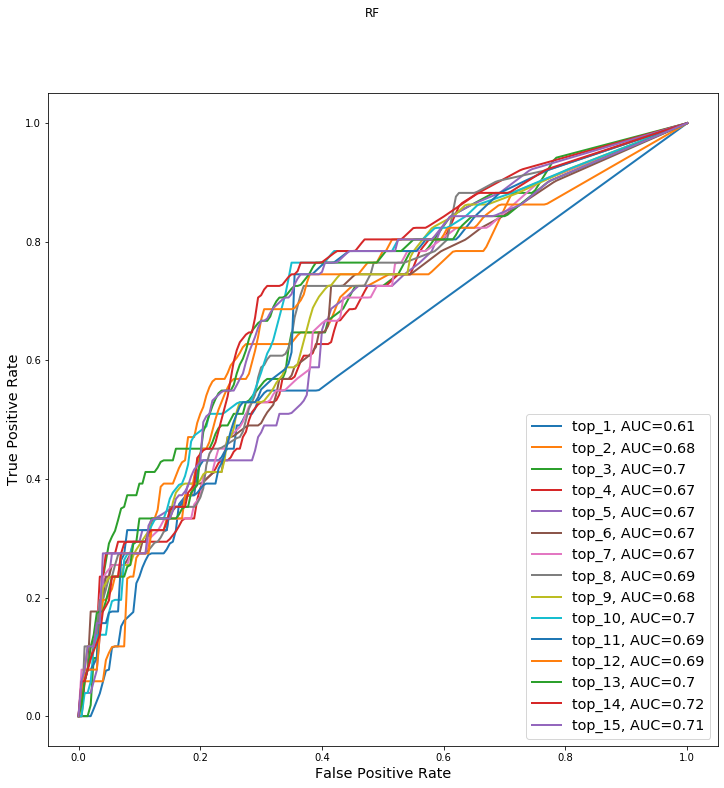

top_1: ['NPM1']
Shape of training data is (249, 1)
Shape of test data is (249, 1)
LR: [0.81124498 0.11764706 0.98989899 0.24612664 0.70786294]
top_2: ['NPM1' 'ATP2B4']
Shape of training data is (249, 2)
Shape of test data is (249, 2)
LR: [0.79116466 0.50980392 0.86363636 0.36819075 0.71182412]
top_3: ['NPM1' 'ATP2B4' 'WFDC2']
Shape of training data is (249, 3)
Shape of test data is (249, 3)
LR: [0.78714859 0.49019608 0.86363636 0.35130194 0.69677164]
top_4: ['NPM1' 'ATP2B4' 'WFDC2' 'CSRP2']
Shape of training data is (249, 4)
Shape of test data is (249, 4)
LR: [0.78313253 0.39215686 0.88383838 0.29468053 0.70548623]
top_5: ['NPM1' 'ATP2B4' 'WFDC2' 'CSRP2' 'RET']
Shape of training data is (249, 5)
Shape of test data is (249, 5)
LR: [0.76305221 0.39215686 0.85858586 0.25652363 0.68082789]
top_6: ['NPM1' 'ATP2B4' 'WFDC2' 'CSRP2' 'RET' 'MAD2L1']
Shape of training data is (249, 6)
Shape of test data is (249, 6)
LR: [0.71485944 0.39215686 0.7979798  0.17942255 0.69340463]
top_7: ['NPM1' 'ATP2

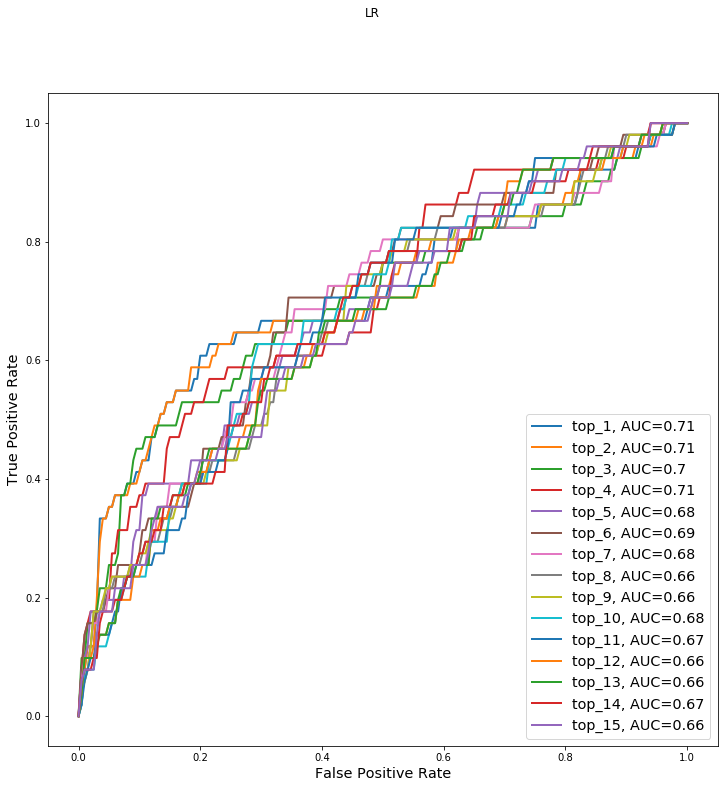

top_1: ['NPM1']
Shape of training data is (249, 1)
Shape of test data is (249, 1)
XGB: [0.7188755  0.39215686 0.8030303  0.18525338 0.64433551]
top_2: ['NPM1' 'ATP2B4']
Shape of training data is (249, 2)
Shape of test data is (249, 2)
XGB: [0.75100402 0.2745098  0.87373737 0.16461226 0.66339869]
top_3: ['NPM1' 'ATP2B4' 'WFDC2']
Shape of training data is (249, 3)
Shape of test data is (249, 3)
XGB: [0.77108434 0.33333333 0.88383838 0.23868098 0.64740543]
top_4: ['NPM1' 'ATP2B4' 'WFDC2' 'CSRP2']
Shape of training data is (249, 4)
Shape of test data is (249, 4)
XGB: [0.72690763 0.29411765 0.83838384 0.13665132 0.66171519]
top_5: ['NPM1' 'ATP2B4' 'WFDC2' 'CSRP2' 'RET']
Shape of training data is (249, 5)
Shape of test data is (249, 5)
XGB: [0.74698795 0.29411765 0.86363636 0.17001541 0.65532779]
top_6: ['NPM1' 'ATP2B4' 'WFDC2' 'CSRP2' 'RET' 'MAD2L1']
Shape of training data is (249, 6)
Shape of test data is (249, 6)
XGB: [0.75100402 0.29411765 0.86868687 0.1771579  0.66359675]
top_7: ['NPM1'

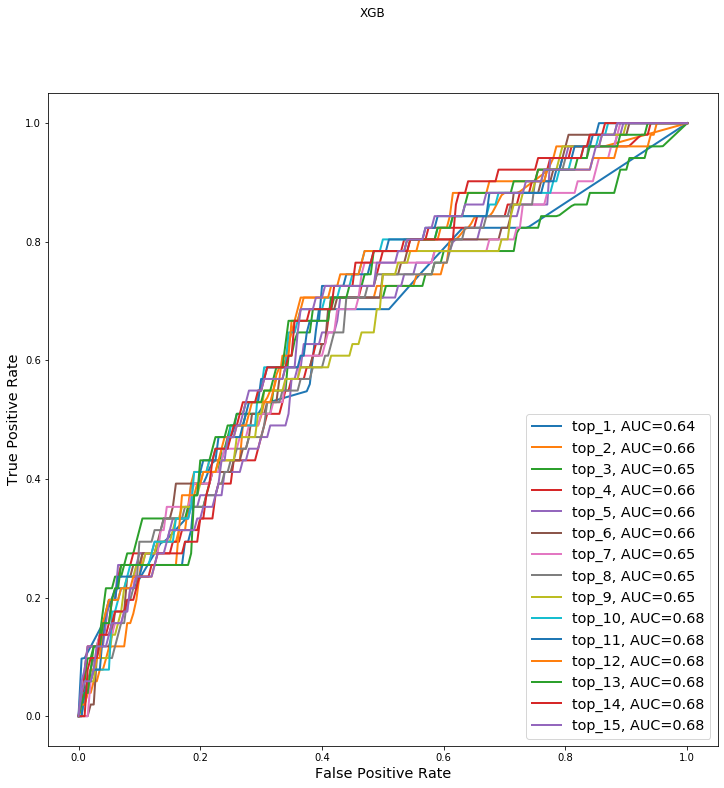

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print('Performance reported using:\t ACC\tSn\tSp\tMCC\tAUC')



    for model in models:
        plt.figure(figsize=(12, 12))
        plt.xlabel('False Positive Rate', fontsize='x-large')
        plt.ylabel('True Positive Rate', fontsize='x-large')

        for markers in markers_sets:
            print('{0}: {1}'.format(markers[0], markers[1]))
            new_df = df[markers[1]].copy()
            X_train = new_df.values
            new_df_test = df_test[markers[1]].copy()
            X_test = new_df_test.values
            # Normalize per sample?
            if is_normalize_samples:
                minMax_filter = MinMaxScaler()
                X_train = minMax_filter.fit_transform(X_train.T, y_train).T
                X_test = minMax_filter.transform(X_test)
            # Normalize per column?
            if is_normalize_columns:
                minMax_filter = MinMaxScaler()
                X_train = minMax_filter.fit_transform(X_train, y_train)
                X_test = minMax_filter.transform(X_test)

            print('Shape of training data is {}'.format(np.shape(X_train)))
            print('Shape of test data is {}'.format(np.shape(X_test)))


            res = do_train_test(X_train, y_train, X_test, y_test, model=model[1], fs_model=None)
            print('{0}: {1}'.format(model[0], res['metrics']))
            plt.plot(res['fpr'], res['tpr'], label=markers[0]+', AUC='+str(round(res['metrics'][4],2)), linewidth=2)

        leg = plt.legend(loc='best', fontsize='x-large')
        plt.suptitle(model[0])
        print('----------------------------------------------------------------------------------------------------')
        plt.show()



We noted that the best performance is obrained using LR classifier and top2 markers.

## ROC for different classifiers using the optimal number of markers

top_3: ['NPM1' 'ATP2B4' 'WFDC2']
Shape of training data is (249, 3)
Shape of test data is (249, 3)
RF: [0.79116466 0.39215686 0.89393939 0.31131946 0.69632601]
top_3: ['NPM1' 'ATP2B4' 'WFDC2']
Shape of training data is (249, 3)
Shape of test data is (249, 3)
LR: [0.78714859 0.49019608 0.86363636 0.35130194 0.69677164]
top_3: ['NPM1' 'ATP2B4' 'WFDC2']
Shape of training data is (249, 3)
Shape of test data is (249, 3)
XGB: [0.77108434 0.33333333 0.88383838 0.23868098 0.64740543]


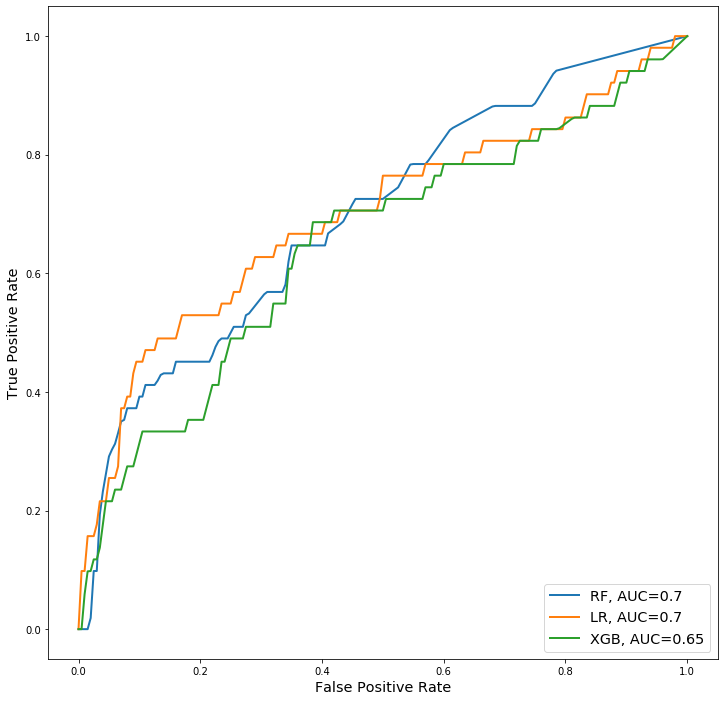

In [7]:
markers_sets =[('top_3',features[:3])]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    plt.figure(figsize=(12, 12))
    plt.xlabel('False Positive Rate', fontsize='x-large')
    plt.ylabel('True Positive Rate', fontsize='x-large')


    for model in models:
        for markers in markers_sets:
            print('{0}: {1}'.format(markers[0], markers[1]))
            new_df = df[markers[1]].copy()
            X_train = new_df.values
            new_df_test = df_test[markers[1]].copy()
            X_test = new_df_test.values
            # Normalize per sample?
            if is_normalize_samples:
                minMax_filter = MinMaxScaler()
                X_train = minMax_filter.fit_transform(X_train.T, y_train).T
                X_test = minMax_filter.transform(X_test)
            # Normalize per column?
            if is_normalize_columns:
                minMax_filter = MinMaxScaler()
                X_train = minMax_filter.fit_transform(X_train, y_train)
                X_test = minMax_filter.transform(X_test)

            print('Shape of training data is {}'.format(np.shape(X_train)))
            print('Shape of test data is {}'.format(np.shape(X_test)))


            res = do_train_test(X_train, y_train, X_test, y_test, model=model[1], fs_model=None)
            print('{0}: {1}'.format(model[0], res['metrics']))
            plt.plot(res['fpr'], res['tpr'], label=model[0]+', AUC='+str(round(res['metrics'][4],2)), linewidth=2)

    leg = plt.legend(loc='lower right', fontsize='x-large')
    #plt.suptitle(target_model[0])
    plt.show()

## Performance of final model using different choices of the threshold for binarizing the predictions

In [8]:
model = ('LR', SGDClassifier(loss="log", penalty="l2", random_state=seed))
markers_sets =[('top_3',features[:3])]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    print('ACC\tSn\tSp\tMCC\tAUC')
    for thrd in range(0,101,2):
        for markers in markers_sets:
            new_df = df[markers[1]].copy()
            X_train = new_df.values
            new_df_test = df_test[markers[1]].copy()
            X_test = new_df_test.values
            # Normalize per sample?
            if is_normalize_samples:
                minMax_filter = MinMaxScaler()
                X_train = minMax_filter.fit_transform(X_train.T, y_train).T
                X_test = minMax_filter.transform(X_test)
             # Normalize per column?
            if is_normalize_columns:
                minMax_filter = MinMaxScaler()
                X_train = minMax_filter.fit_transform(X_train, y_train)
                X_test = minMax_filter.transform(X_test)

            res = do_train_test(X_train, y_train, X_test, y_test, model=model[1], fs_model=None,  threshold=thrd/100.0)
            print('{0}: {1}'.format(thrd/100.0, res['metrics']))


ACC	Sn	Sp	MCC	AUC
0.0: [0.20481928 1.         0.         0.         0.69677164]
0.02: [0.21285141 1.         0.01010101 0.04566874 0.69677164]
0.04: [0.24497992 0.96078431 0.06060606 0.0374747  0.69677164]
0.06: [0.31726908 0.88235294 0.17171717 0.05942536 0.69677164]
0.08: [0.40160643 0.82352941 0.29292929 0.1059782  0.69677164]
0.1: [0.5060241  0.78431373 0.43434343 0.18095631 0.69677164]
0.12: [0.55421687 0.76470588 0.5        0.21492169 0.69677164]
0.14: [0.58634538 0.70588235 0.55555556 0.21101843 0.69677164]
0.16: [0.61044177 0.68627451 0.59090909 0.22424894 0.69677164]
0.18: [0.63453815 0.66666667 0.62626263 0.23853881 0.69677164]
0.2: [0.65863454 0.64705882 0.66161616 0.25411247 0.69677164]
0.22: [0.66666667 0.62745098 0.67676768 0.25224479 0.69677164]
0.24: [0.6746988  0.62745098 0.68686869 0.26167333 0.69677164]
0.26: [0.69477912 0.62745098 0.71212121 0.2859531  0.69677164]
0.28: [0.69879518 0.58823529 0.72727273 0.26930628 0.69677164]
0.3: [0.70281124 0.58823529 0.73232323 0

- The highest MCC of 0.38 is reached using threshold = 0.58
- Sp of 0.9 is reached using threshold = 0.60
- Sp of 0.95 is reached using threshold = 0.74

## Final model vs model using all DEGs

In [9]:
# load DEGs if provided
if degs_file is not None:
    DEGs = load_DEGs(degs_file)
    print('{} DEGs loaded!'.format(len(DEGs)))
else:
    print('No DEGs provided.')

194 DEGs loaded!


In [10]:
top3_ml = features[:3]
markers_sets =[
               ('top3_ml', top3_ml),
               ('DEGs', DEGs)
]
models = [
  ('LR', SGDClassifier(loss="log", penalty="l2", random_state=seed)),
 ]


top3_ml: ['NPM1' 'ATP2B4' 'WFDC2']
Shape of training data is (249, 3)
Shape of test data is (249, 3)
LR: [0.78714859 0.49019608 0.86363636 0.35130194 0.69677164]
DEGs: ['WSB1', 'CES4A', 'CSRP2', 'MAD2L1', 'CKS2', 'C17orf107', 'NRBP2', 'DLGAP5', 'PAICS', 'CDKN3', 'UBE2S', 'NPM1', 'EXO1', 'GDPD5', 'CENPA', 'FAM83D', 'MND1', 'HMGB3', 'KIF4A', 'ODC1', 'AHCY', 'AURKA', 'SLC1A5', 'UHRF1', 'PGM2L1', 'MIAT', 'FEN1', 'RPS7', 'PCNA', 'ADCY1', 'DEPDC1B', 'NCAPG', 'ORC6', 'CCNA2', 'CHD5', 'CCNB1', 'RPL22L1', 'PLEKHG5', 'PLXNA4', 'HMGB2', 'CENPF', 'MLF1IP', 'CDRT4', 'COL7A1', 'CDK1', 'MCM2', 'ALS2CL', 'RCOR2', 'RNASEH2A', 'C9orf140', 'CAPN5', 'TYMS', 'PVRL1', 'PLK1', 'TNFRSF25', 'CCNB2', 'CDCA5', 'TPX2', 'PSAT1', 'KIF11', 'C19orf48', 'PTTG1', 'RMI2', 'HJURP', 'SPC24', 'MYCNOS', 'BUB1B', 'NEAT1', 'BIRC5', 'DTL', 'ECEL1', 'MYCN', 'NRCAM', 'PTPRH', 'INSRR', 'ETV1', 'PLCD4', 'KIF20A', 'CDT1', 'ABLIM3', 'NTRK1', 'UBE2C', 'PBK', 'NUF2', 'C5orf4', 'E2F1', 'MAP7', 'PCDHGB6', 'PLXNC1', 'CBLN1', 'HOXC9', 'NU

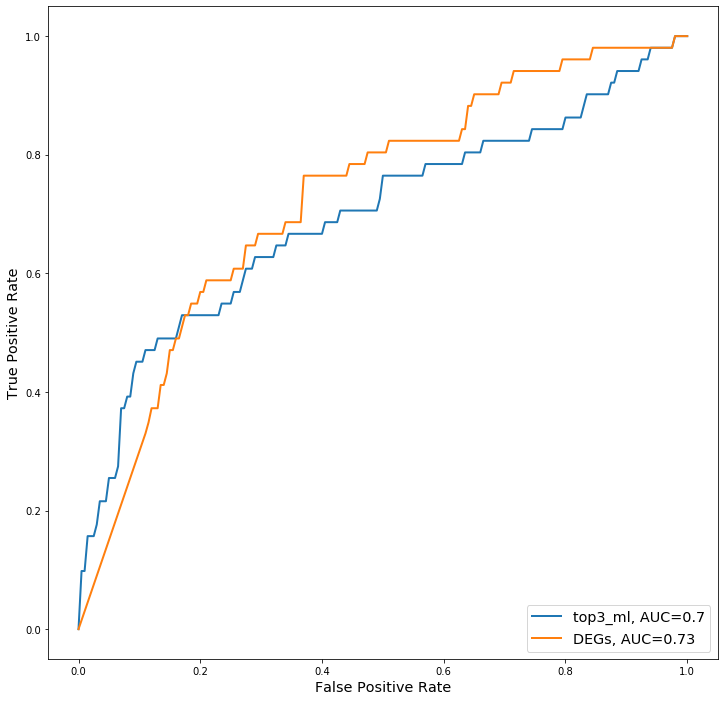

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    plt.figure(figsize=(12, 12))
    plt.xlabel('False Positive Rate', fontsize='x-large')
    plt.ylabel('True Positive Rate', fontsize='x-large')


    for model in models:
        for markers in markers_sets:
            print('{0}: {1}'.format(markers[0], markers[1]))
            new_df = df[markers[1]].copy()
            X_train = new_df.values
            new_df_test = df_test[markers[1]].copy()
            X_test = new_df_test.values
            # Normalize per sample?
            if is_normalize_samples:
                minMax_filter = MinMaxScaler()
                X_train = minMax_filter.fit_transform(X_train.T, y_train).T
                X_test = minMax_filter.transform(X_test)
            # Normalize per column?
            if is_normalize_columns:
                minMax_filter = MinMaxScaler()
                X_train = minMax_filter.fit_transform(X_train, y_train)
                X_test = minMax_filter.transform(X_test)

            print('Shape of training data is {}'.format(np.shape(X_train)))
            print('Shape of test data is {}'.format(np.shape(X_test)))


            res = do_train_test(X_train, y_train, X_test, y_test, model=model[1], fs_model=None)
            print('{0}: {1}'.format(model[0], res['metrics']))
            plt.plot(res['fpr'], res['tpr'], label=markers[0]+', AUC='+str(round(res['metrics'][4],2)), linewidth=2)

    leg = plt.legend(loc='lower right', fontsize='x-large')
    #plt.suptitle(target_model[0])
    plt.show()

We note that, for specificity > 0.8, the LR model using only top 3 marker genes has a better sensitivity than the LR model trained using all DEGs.